In [82]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import precision_recall_curve
from keras.models import Sequential

# import sys
# sys.path.insert(0,'/Users/hagiwara/code/mohit-challa/GiveMeSomeCredit/notebooks/utils')
# from plots import plot_decision_regions

In [2]:
df = pd.read_csv('../raw_data/BankChurners.csv')
df.drop(['CLIENTNUM','Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1','Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2'], axis=1, inplace=True)

In [3]:
df.head()

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


## Exploring corelations with heatmap

<AxesSubplot:>

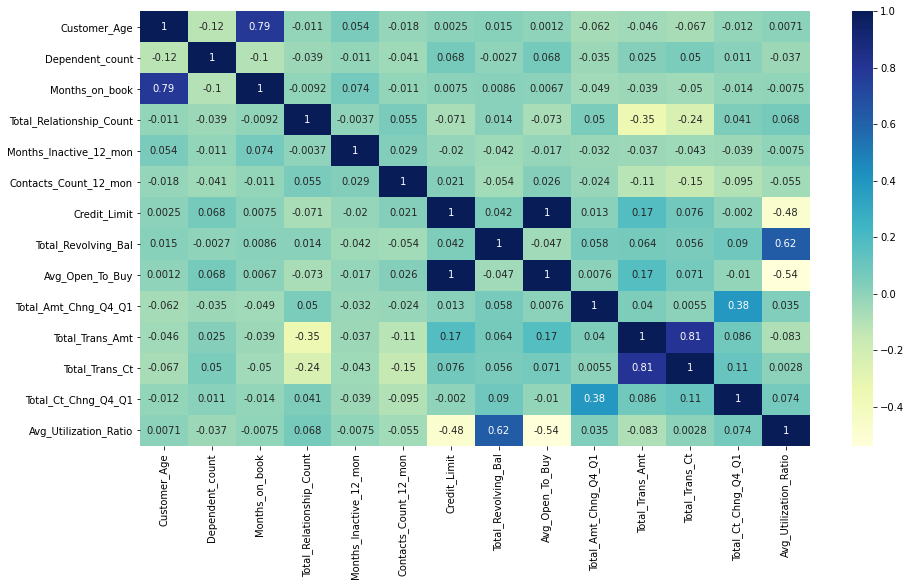

In [4]:
corr = df.corr()

fig, ax = plt.subplots(figsize=(15,8)) 

sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        cmap= "YlGnBu",
        annot=True,
        ax=ax)

In [5]:
corr_df = corr.unstack().reset_index() # Unstack correlation matrix 
corr_df.columns = ['feature_1','feature_2', 'correlation'] # rename columns
corr_df.sort_values(by="correlation",ascending=False, inplace=True) # sort by correlation
corr_df = corr_df[corr_df['feature_1'] != corr_df['feature_2']] # Remove self correlation

In [6]:
corr_df.head()

,feature_1,feature_2,correlation
118,Avg_Open_To_Buy,Credit_Limit,0.995981
92,Credit_Limit,Avg_Open_To_Buy,0.995981
151,Total_Trans_Amt,Total_Trans_Ct,0.807192
164,Total_Trans_Ct,Total_Trans_Amt,0.807192
28,Months_on_book,Customer_Age,0.788912


Dropping the `Avg_Open_To_Buy` column because of high corelation with `Credit_Limit`

In [7]:
df.drop('Avg_Open_To_Buy',axis=1, inplace=True)

## Hold-out

In [23]:
X = df.drop('Attrition_Flag', axis=1)
y = df[['Attrition_Flag']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [24]:
X_train.head()

,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
4813,47,M,2,Graduate,Divorced,$80K - $120K,Blue,40,6,1,3,16741.0,1225,0.641,3608,56,0.514,0.073
9887,54,M,1,Unknown,Single,$60K - $80K,Blue,48,4,5,4,4752.0,1230,0.883,15678,103,0.717,0.259
4191,41,F,4,Uneducated,Married,Less than $40K,Blue,33,5,2,3,2888.0,821,0.931,4713,77,1.026,0.284
7527,48,F,3,Graduate,Married,Unknown,Blue,39,3,1,2,6130.0,1741,0.578,4264,63,0.658,0.284
5081,49,M,4,College,Divorced,$120K +,Blue,41,3,1,1,7184.0,1207,0.657,3244,58,1.000,0.168


## Pre-processing function

In [25]:
def preprocessing(X1,y1):
    
    X=X1.copy()
    y=y1.copy()
    #Encodingg gender
    onehot_encoder = OneHotEncoder(sparse=False, drop='if_binary')
    onehot_encoder.fit(X[['Gender']])
    X['Male'] = onehot_encoder.transform(X[['Gender']])
    X.drop(['Gender'], axis=1, inplace=True)
    
    #Encodingg marital status
    onehot_encoder.fit(X[['Marital_Status']])
    X['Status_Divorced'], X['Status_Married'], X['Status_Single'], X['Status_Unknown'] = onehot_encoder.transform(X[['Marital_Status']]).T
    X.drop(['Marital_Status'], axis=1, inplace=True)
    
    #Mapping educational_level
    edu_dict = {'Unknown':2.5, 'Uneducated':0, 'High School':1, 'College':2, 'Graduate':3, 'Post-Graduate':4, 'Doctorate':5}
    X['Education_Level'] = X['Education_Level'].map(edu_dict)
    
    #Mapping income_category
    income_dict = {'Unknown':2 , 'Less than $40K':0, '$40K - $60K':1, '$60K - $80K':2, '$80K - $120K':3, '$120K +':4}
    X['Income_Category'] = X['Income_Category'].map(income_dict)
    
    #Mapping card_category
    card_dict = {'Blue':0, 'Silver':1, 'Gold':2, 'Platinum':3}
    X['Card_Category'] = X['Card_Category'].map(card_dict)
    
    #Scaling
    std_scaler = StandardScaler()
    std_scaler.fit(X)
    X_scaled = pd.DataFrame(std_scaler.transform(X))
    X = pd.DataFrame(data=X_scaled.values, columns=X.columns)
    
    #Encoding Attrition_flag
    onehot_encoder.fit(y[['Attrition_Flag']])
    y['Existing Customer'] = onehot_encoder.transform(y[['Attrition_Flag']])
    y.drop('Attrition_Flag', axis=1, inplace=True)
    
    return X, y

In [26]:
X_train, y_train = preprocessing(X_train, y_train)
#X_test, y_test = preprocessing(X_test, y_test)

## Handling class imbalance using SMOTE

In [29]:
print('Before handling imbalance:\n', y_train.value_counts())
oversample = SMOTE(random_state=0)
X_train, y_train = oversample.fit_resample(X_train, y_train)
print('\nAfter handling imbalance:\n', y_train.value_counts())

Before handling imbalance:
 Existing Customer
1.0                  5917
0.0                  1171
dtype: int64

After handling imbalance:
 Existing Customer
0.0                  5917
1.0                  5917
dtype: int64


<AxesSubplot:>

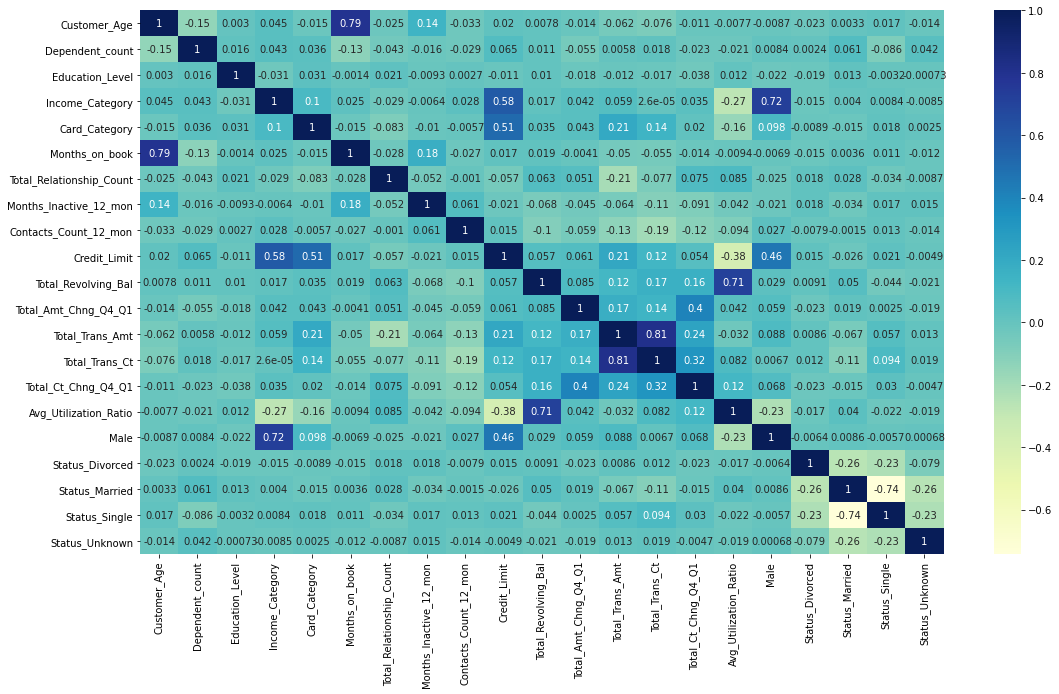

In [30]:
corr = X_train.corr()

fig, ax = plt.subplots(figsize=(18,10)) 

sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns,
        cmap= "YlGnBu",
        annot=True,
        ax=ax)

In [31]:
corr_trained = corr.unstack().reset_index() # Unstack correlation matrix 
corr_trained.columns = ['feature_1','feature_2', 'correlation'] # rename columns
corr_trained.sort_values(by="correlation",ascending=False, inplace=True) # sort by correlation
corr_trained = corr_trained[corr_trained['feature_1'] != corr_trained['feature_2']] # Remove self correlation

In [32]:
corr_trained.head()

,feature_1,feature_2,correlation
285,Total_Trans_Ct,Total_Trans_Amt,0.812067
265,Total_Trans_Amt,Total_Trans_Ct,0.812067
105,Months_on_book,Customer_Age,0.792208
5,Customer_Age,Months_on_book,0.792208
339,Male,Income_Category,0.721377


### Pre-processing the test set

In [ ]:
#X_val, y_val = X_test,y_test

In [33]:
X_val, y_val=preprocessing(X_test,y_test)

In [34]:
X_test

,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
3358,44,M,5,Uneducated,Divorced,$60K - $80K,Blue,39,5,2,0,16034.0,1597,0.775,3628,59,0.903,0.100
9951,44,F,3,Unknown,Single,Unknown,Blue,34,2,3,3,26021.0,0,1.040,8898,60,0.538,0.000
3848,37,F,3,High School,Single,Less than $40K,Blue,26,3,1,2,2917.0,2216,0.810,4524,67,0.489,0.760
1666,34,M,1,Graduate,Married,$40K - $60K,Blue,36,6,2,3,3735.0,1285,1.034,1877,33,1.200,0.344
8383,51,F,4,High School,Single,Less than $40K,Blue,33,2,4,3,3068.0,2071,0.854,5524,71,0.972,0.675
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7707,52,M,4,High School,Unknown,$60K - $80K,Blue,36,6,3,2,2597.0,1740,0.710,5037,80,0.778,0.670
8643,43,F,4,Graduate,Married,Less than $40K,Blue,35,3,3,0,6448.0,1464,0.615,7546,88,0.630,0.227
8191,59,F,1,High School,Single,Unknown,Blue,52,2,1,1,7427.0,2421,0.701,4636,91,0.820,0.326
4542,44,M,1,Graduate,Single,$60K - $80K,Blue,37,3,1,4,16739.0,1229,0.497,4014,69,0.568,0.073


## Logistic Regression: Cross Validation

In [35]:
log_model = LogisticRegression()
log_model.fit(X_train,y_train)

LogisticRegression()

In [36]:
log_cv_results = cross_validate(log_model, X_val, y_val, cv=10, 
                            scoring=['accuracy','recall','precision','f1'])

In [37]:
print('Accuracy:\n', log_cv_results['test_accuracy'].mean())
print('\nRecall\n', log_cv_results['test_recall'].mean())
print('\nPrecision\n', log_cv_results['test_precision'].mean())
print('\nf1:\n', log_cv_results['test_f1'].mean())

Accuracy:
 0.900954273058885

Recall
 0.964379994612553

Precision
 0.9229008248484545

f1:
 0.9430532107259164


## KNN Classifier

In [38]:
knn_model = KNeighborsClassifier(n_neighbors=3, p=1)
knn_model.fit(X_train,y_train)

KNeighborsClassifier(n_neighbors=3, p=1)

In [39]:
knn_cv_results = cross_validate(knn_model, X_val, y_val, cv=10, 
                            scoring=['accuracy','recall','precision','f1'], n_jobs = -1) 

In [40]:
print('Accuracy:\n', knn_cv_results['test_accuracy'].mean())
print('\nRecall:\n', knn_cv_results['test_recall'].mean())
print('\nPrecision:\n', knn_cv_results['test_precision'].mean())
print('\nf1:\n', knn_cv_results['test_f1'].mean())

Accuracy:
 0.9012723640785131

Recall:
 0.9721199604920535

Precision:
 0.9168057778361316

f1:
 0.9435941270096182


#### Grid searching the KNN model

Cell converted to markdown after getting the `best_params`

knn_model = KNeighborsClassifier()

k_grid = {'n_neighbors' : [2,3,4,5], 'p': [1,2,3]}

knn_grid = GridSearchCV(knn_model, k_grid, n_jobs=-1,  cv = 10)

knn_grid.fit(X_train, y_train)

`best_params`: {'n_neighbors': 3, 'p': 1}

Update `knn_cv_results` with the best params.

## SVM

In [41]:
svm_model = SVC(C=100, kernel='poly', probability=True)
svm_model.fit(X_train, y_train)

SVC(C=100, kernel='poly', probability=True)

In [42]:
svm_cv_results = cross_validate(svm_model, X_val, y_val, cv=5, 
                            scoring=['accuracy','recall','precision','f1'], n_jobs = -1) 

In [43]:
print('Accuracy:\n', svm_cv_results['test_accuracy'].mean())
print('\nRecall:\n', svm_cv_results['test_recall'].mean())
print('\nPrecision:\n', svm_cv_results['test_precision'].mean())
print('\nf1:\n', svm_cv_results['test_f1'].mean())

Accuracy:
 0.8749539365299576

Recall:
 0.9179209212361117

Precision:
 0.9338946075625794

f1:
 0.9257629834965589


#### Grid searching the SVM model

Cell converted to markdown after getting the `best_params`

svm_model = SVC()

s_grid = {'kernel' : ['linear', 'poly', 'sigmoid'], 'C': [1,10,100]}

svm_grid = GridSearchCV(svm_model, s_grid, n_jobs=-1,  cv = 10)

svm_grid.fit(X_train, y_train)

`best_params`: {'C': 100, 'kernel': 'poly'}

## Random Forest

In [44]:
rf_model = RandomForestClassifier(criterion='entropy', min_samples_split=2, n_estimators=500)
rf_model.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', n_estimators=500)

In [45]:
rf_cv_results = cross_validate(rf_model, X_val, y_val, cv=5, 
                            scoring=['accuracy','recall','precision','f1'], n_jobs = -1) 

In [46]:
print('Accuracy:\n', rf_cv_results['test_accuracy'].mean())
print('\nRecall:\n', rf_cv_results['test_recall'].mean())
print('\nPrecision:\n', rf_cv_results['test_precision'].mean())
print('\nf1:\n', rf_cv_results['test_f1'].mean())

Accuracy:
 0.9486657851382988

Recall:
 0.9907081702727423

Precision:
 0.9511002804064566

f1:
 0.9704520115967039


#### Grid searching the RF model

Cell converted to markdown after getting the `best_params`

rf_model = RandomForestClassifier()

r_grid = {'n_estimators': [100, 200, 500], 'criterion':["gini", "entropy"], 'min_samples_split':[2,3,4]}

rf_grid = GridSearchCV(rf_model, r_grid, n_jobs=-1, cv = 5)

rf_grid.fit(X_train, y_train)

`best_params`: {'criterion': 'entropy', 'min_samples_split': 2, 'n_estimators': 500}

## Inspecting AUC scores to select the best model

In [47]:
log_auc_score = roc_auc_score(y_val, log_model.predict_proba(X_val)[:,1], multi_class='ovr')
knn_auc_score = roc_auc_score(y_val, knn_model.predict_proba(X_val)[:,1], multi_class='ovr')
svm_auc_score = roc_auc_score(y_val, svm_model.predict_proba(X_val)[:,1], multi_class='ovr')
rf_auc_score = roc_auc_score(y_val, rf_model.predict_proba(X_val)[:,1], multi_class='ovr')

print(log_auc_score)
print(knn_auc_score)
print(svm_auc_score)
print(rf_auc_score)

0.9243679999456635
0.8814541434888034
0.910420529643893
0.9808205303230977


Text(0.5, 1.0, 'Precision-Recall curves')

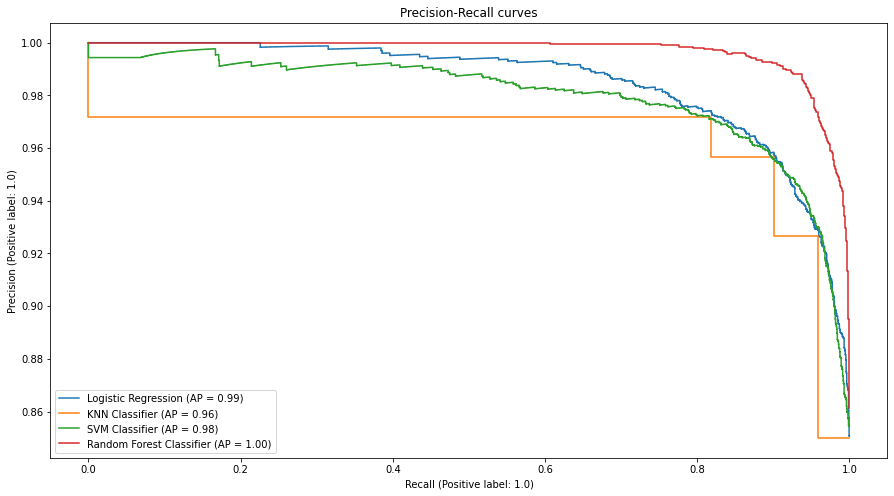

In [48]:
fig = plt.gcf()
fig.set_size_inches(15, 8)

plot_precision_recall_curve(log_model, X_val, y_val, ax = plt.gca(),name = 'Logistic Regression')
plot_precision_recall_curve(knn_model, X_val, y_val, ax = plt.gca(),name = 'KNN Classifier')
plot_precision_recall_curve(svm_model, X_val, y_val, ax = plt.gca(),name = 'SVM Classifier')
plot_precision_recall_curve(rf_model, X_val, y_val, ax = plt.gca(),name = 'Random Forest Classifier')

plt.title('Precision-Recall curves')

### From precision-recall curves, Random Forest classifier is the best model for the given task.

## Threshold Adjustment
Finding the decision threshold that guarantees a 95% precision for predicting customer attrition.

In [69]:
# Predict probabilities
y_pred_probas_0, y_pred_probas_1 = cross_val_predict(rf_model,
                                                     X_val, np.array(y_val).flatten(),
                                                     method = "predict_proba").T

# Generate precision and thresholds (and recalls) using probabilities for class 1
precision, recall, thresholds = precision_recall_curve(y_val, y_pred_probas_1)

# Populate dataframe with precision and threshold
df_precision = pd.DataFrame({"precision" : precision[:-1], "threshold" : thresholds})

# Find out which threshold guarantees a precision of 0.95
new_threshold = df_precision[df_precision['precision'] >= 0.95]['threshold'].min()

new_threshold

0.492

## Deep Learning Test 1

In [70]:
''' Linear Algebra'''
import pandas as pd
import numpy as np

''' Data visualisation'''
import matplotlib.pyplot as plt 
import seaborn as sns
import warnings

''' Scikit-Learn'''
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import confusion_matrix

''' Imbalanced Classes'''
import imblearn
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

''' Tensorflow Keras'''
from tensorflow import keras
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

In [71]:
metrics = [
    keras.metrics.Recall(),
    keras.metrics.Precision(),
    keras.metrics.AUC(name='prc', curve='PR'),  # precision-recall curve
]

In [72]:
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.metrics import Recall, Precision

def init_model():
    input_shape = X_train.shape[1:]
    #normalizer = Normalization()
    #normalizer.adapt(X_train)
    
    model = models.Sequential()
    model.add(layers.Dense(21, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(8, activation='relu'))
    model.add(layers.Dropout(0.3))
    model.add(layers.Dense(1, activation = 'sigmoid'))

    # Model compilation
    optimizer = Adam(lr=0.0001)
    model.compile(loss='binary_crossentropy',
                  optimizer=optimizer,
                  metrics=metrics)
    return model

In [73]:
model = init_model()
#model.summary()

In [74]:
es = EarlyStopping(
    patience=10,
    monitor='val_recall', # We really want to detect fraudulent transactions!
    restore_best_weights=True)

history = model.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=100,
                    batch_size=64, # Large enough to get a decent chance of conatining fraudulent transactions 
                    callbacks=[es], shuffle=True)

Epoch 1/100
185/185 [==============================] - 3s 9ms/step - loss: 0.7248 - recall: 0.4438 - precision: 0.5361 - prc: 0.5520 - val_loss: 0.7048 - val_recall: 0.4642 - val_precision: 0.9195 - val_prc: 0.9097
Epoch 2/100
185/185 [==============================] - 1s 3ms/step - loss: 0.6983 - recall: 0.5026 - precision: 0.5571 - prc: 0.5795 - val_loss: 0.6666 - val_recall: 0.5858 - val_precision: 0.9328 - val_prc: 0.9241
Epoch 3/100
185/185 [==============================] - 1s 3ms/step - loss: 0.6733 - recall: 0.5532 - precision: 0.5805 - prc: 0.6086 - val_loss: 0.6457 - val_recall: 0.6365 - val_precision: 0.9378 - val_prc: 0.9368
Epoch 4/100
185/185 [==============================] - 0s 3ms/step - loss: 0.6453 - recall: 0.6174 - precision: 0.6069 - prc: 0.6566 - val_loss: 0.6214 - val_recall: 0.6907 - val_precision: 0.9449 - val_prc: 0.9459
Epoch 5/100
185/185 [==============================] - 1s 3ms/step - loss: 0.6333 - recall: 0.6437 - precision: 0.6213 - prc: 0.6773 - val_l

In [75]:
def plot_history(history, metric):
    plt.plot(history.history[f'{metric}'])
    plt.plot(history.history[f'val_{metric}'])
    plt.title(f'Model {metric}')
    plt.ylabel(f'{metric}')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Val'], loc='best')
    plt.show()

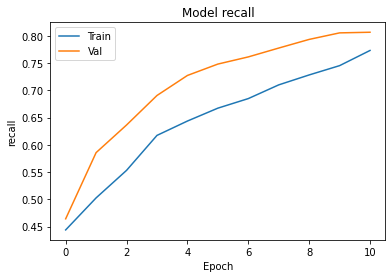

In [76]:
plot_history(history, "recall")

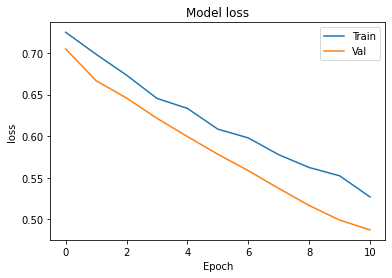

In [77]:
plot_history(history, "loss")

In [79]:
model.evaluate(X_val, y_val, verbose=0, return_dict=True)

{'loss': 0.7047889232635498,
 'recall': 0.46418893337249756,
 'precision': 0.9194785356521606,
 'prc': 0.90966796875}

In [ ]:
X_val

## Deep Learning Test 2

In [101]:
# Usual syntax

model = Sequential()
model.add(layers.Dense(30, input_dim=10, activation='relu'))
model.add(layers.Dense(30, input_shape=(10,), activation='relu'))
model.add(layers.Dense(1))
model.build(input_shape=X_train.shape[1:])
model.summary()

ValueError: Input 0 of layer dense_36 is incompatible with the layer: : expected min_ndim=2, found ndim=1. Full shape received: (21,)

In [97]:
model = Sequential()
model.add(layers.Masking(mask_value=-1., input_shape=X_train.shape[1:]))
model.add(layers.GRU(units=21, activation='tanh', return_sequences=True))
model.add(layers.GRU(units=21, activation='tanh', return_sequences=False))
model.add(layers.Dense(50, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(1, activation='sigmoid'))
model.build(input_shape=X_train.shape[1:])
model.summary()

ValueError: Input 0 of layer gru_24 is incompatible with the layer: expected ndim=3, found ndim=1. Full shape received: (21,)